
Bootstrapped logistic regression and random forests classification of the Kaggle Titanic problem

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from seaborn import histplot, pairplot

In [2]:
os.chdir("/tmp")

In [3]:
!git clone "https://github.com/ktaylora/EagleKahnXylem"

Cloning into 'EagleKahnXylem'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 31 (delta 12), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (31/31), 151.72 KiB | 1.12 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [4]:
training_data = pd.read_csv("EagleKahnXylem/Titanic/train.csv")
testing_data = pd.read_csv("EagleKahnXylem/Titanic/test.csv")

In [5]:
# lazily side-load our classification codebase from Github
sys.path.append("EagleKahnXylem")
from classification import *

Main Workflow

In [6]:
# if K is too high, we can't use it to estimate reliable std. error for our logistic regression, 
# but large K values makes for pretty predictive intervals for our models. Start low and 
# work high when we are ready to go to predict against our test data
K : int = 999

In [7]:
# encode our ticket text to an integer -- larger numbers = greater complexity
training_data['Ticket'] = [ string_to_ordinal(x) for x in training_data['Ticket'] ]
training_data['Cabin'] = [ string_to_ordinal(x) for x in training_data['Cabin'] ]
training_data['Embarked'] = [ string_to_ordinal(x) for x in training_data['Embarked'] ]
training_data['Name'] = [ string_to_ordinal(x) for x in training_data['Name'] ]
# ditto for our testing dataset
testing_data['Ticket'] = [ string_to_ordinal(x) for x in testing_data['Ticket'] ]
testing_data['Cabin'] = [ string_to_ordinal(x) for x in testing_data['Cabin'] ]
testing_data['Embarked'] = [ string_to_ordinal(x) for x in testing_data['Embarked'] ]
testing_data['Name'] = [ string_to_ordinal(x) for x in testing_data['Name'] ]

In [8]:
# interpolate any remaining NA values
training_data.interpolate(inplace=True)
testing_data.interpolate(inplace=True)

Explore our training data -- some of this I did offline in 'R' with an overfit Random Forests model using all columns in our training dataframe

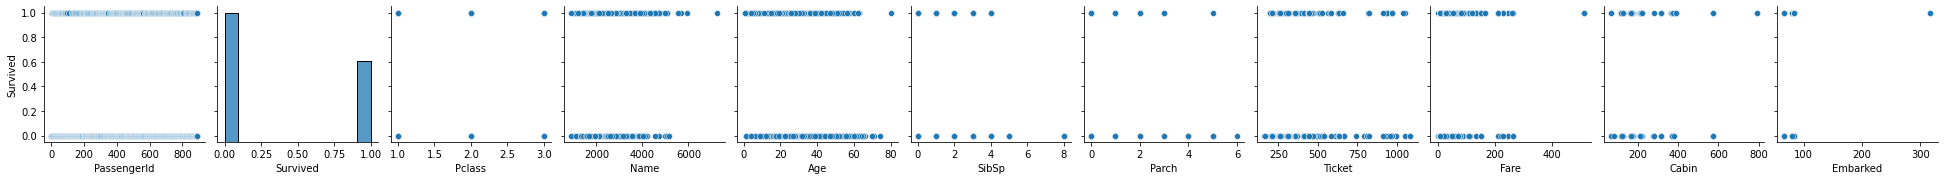

In [9]:
plot = pairplot(training_data, y_vars=['Survived'])

In [10]:
# use a 70/30 split for training/testing for bootstrapping
# and k-folds cross-validation
main_effects = ['Age', 'Fare','Ticket','Cabin','Parch','Pclass','SibSp','Embarked','Name']
k_folds = [ 
  shuffle(training_data, balance_classes=True, frac=0.85) 
  for i in range(K) ]
# bootstrap our logistic regression for estimating a confidence
# interval (standard error) and mean effect sizes from standardized
# coefficients
logistic_regressions = [ fit_logistic_regression(
    df['training'], variables = main_effects, 
    dummy_variables = ['Sex']) for df in k_folds ]

In [11]:
# grab the coefficients and standard error values from our bootstrapped 
# logistic regression classifiers
std_effect_sizes(logistic_regressions)

,est,se
Intercept,0.324272,0.001959
Age,-0.533922,0.002048
Fare,0.324402,0.003538
Ticket,-0.001875,0.001975
Cabin,-0.304766,0.002299
Parch,-0.133847,0.002534
Pclass,-0.609418,0.002708
SibSp,-0.404914,0.002639
Embarked,-0.072774,0.001132
Name,0.323200,0.002537


In [16]:
lreg_cv_results = pd.concat( cross_validation(
  logistic_regressions, k_folds=k_folds, variables=main_effects, 
  dummy_variables=["Sex"], apply_scale = True) )

(0.7840267451917937, 0.11516529635003563)


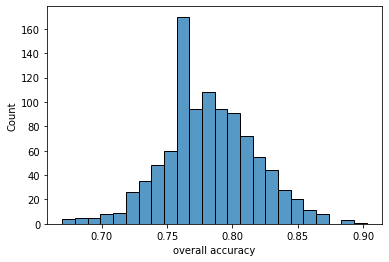

In [17]:
print( (lreg_cv_results['overall accuracy'].mean(), (3 * lreg_cv_results['overall accuracy'].std())) ) 
plot = histplot(lreg_cv_results['overall accuracy'])

(0.19171376434594994, 0.1640794566824769)


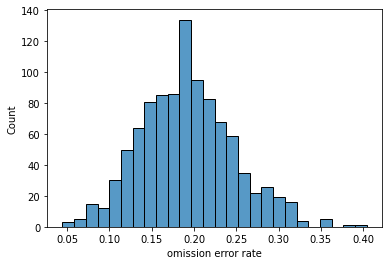

In [18]:
print( ( np.mean(lreg_cv_results['omission error rate']), (3 * np.std(lreg_cv_results['omission error rate'])) ) )
plot = histplot(lreg_cv_results['omission error rate'])

(0.2388343157657155, 0.1768057999137529)


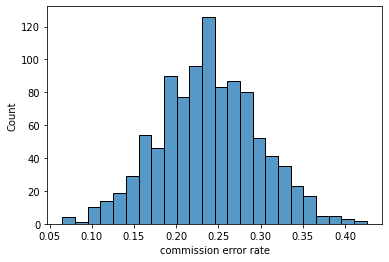

In [19]:
print( ( np.mean(lreg_cv_results['commission error rate']), (3 * np.std(lreg_cv_results['commission error rate'])) ) )
plot = histplot(lreg_cv_results['commission error rate'])

In [20]:
# Fit an exploratory RF classifier across K replicates to these variables -- they seems to be
# consistently important based on our regression modeling
random_forests = [ fit_random_forests(
  df['training'], variables = main_effects, dummy_variables=['Sex']) 
  for df in k_folds ]

In [21]:
rf_cv_results = pd.concat( cross_validation(
  random_forests, k_folds=k_folds, variables=main_effects, 
  dummy_variables=["Sex"], apply_scale = False) )

(0.8025306860258314, 0.11218559699551127)


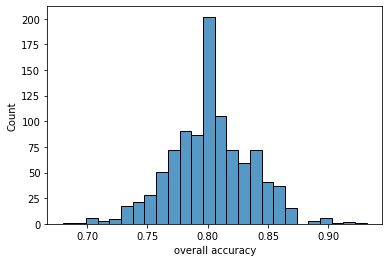

In [22]:
print( (rf_cv_results['overall accuracy'].mean(), (3 * rf_cv_results['overall accuracy'].std())) ) 
plot = histplot(rf_cv_results['overall accuracy'])

(0.17299498985103695, 0.15960182732532305)


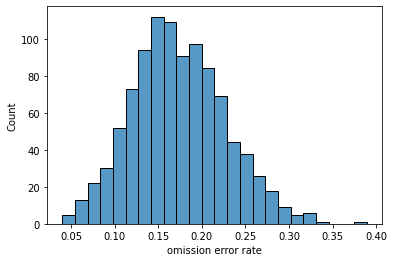

In [23]:
print( ( np.mean(rf_cv_results['omission error rate']), (3 * np.std(rf_cv_results['omission error rate'])) ) )
plot = histplot(rf_cv_results['omission error rate'])

(0.22038877747305266, 0.17528444311636)


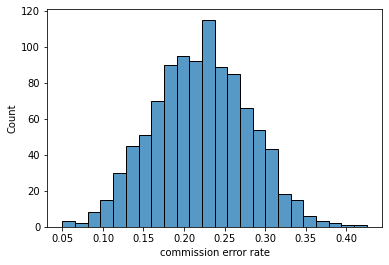

In [24]:
print( ( np.mean(rf_cv_results['commission error rate']), (3 * np.std(rf_cv_results['commission error rate'])) ) )
plot = histplot(rf_cv_results['commission error rate'])

Predict against Kaggle's testing datset and double-check our work by predicting against the full training dataset to make sure we are properly attributing predictions (in order) to passenger id, etc...

In [25]:
ensemble_testing_predictions = [ predict(
    m=m['model'], type="prob",
    x=encode_design_matrix(testing_data, 
      variables = main_effects, dummy_variables=['Sex'], 
      normalize=False)['x']) for m in random_forests ]

In [26]:
ensemble_double_check_predictions = [ predict(
    m=m['model'], type="prob",
    x=encode_design_matrix(training_data, 
      variables = main_effects, dummy_variables=['Sex'], 
      normalize=False)['x']) for m in random_forests ]

In [27]:
def _parse_survivorship_votes(x):
  result = list()
  for i in range(len(x)):
    table = list()
    for j in range(len(x[i])):
      table.append(x[i][j][1])
    result.append(table)
  return result

In [28]:
ensemble_testing_predictions = [ 
  int(i > 0.55) for i in 
  np.average(_parse_survivorship_votes(ensemble_testing_predictions), 
    axis=0, weights=rf_cv_results['overall accuracy']) ]

In [29]:
ensemble_double_check_predictions = [ 
  int(i > 0.55) for i in 
  np.average(_parse_survivorship_votes(ensemble_double_check_predictions), 
    axis=0, weights=rf_cv_results['overall accuracy']) ]

In [30]:
answer = pd.DataFrame(testing_data['PassengerId'])
answer['Survived'] = ensemble_testing_predictions

In [31]:
double_check = pd.DataFrame(training_data[['PassengerId','Survived']])
double_check['Prediction'] = ensemble_double_check_predictions

In [32]:
print(
  " accuracy rate vs. training data (should be close to 1.0):",
    np.sum(double_check['Survived'] == double_check['Prediction']) / len(double_check) )

 accuracy rate vs. training data (should be close to 1.0): 0.9842873176206509


In [33]:
testing_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,1354,male,34.5,0,0,305,7.8292,317,81
1,893,3,2715,female,47.0,1,0,311,7.0000,317,83
2,894,2,2229,male,62.0,0,0,309,9.6875,317,81
3,895,3,1375,male,27.0,0,0,307,8.6625,317,83
4,896,3,3902,female,22.0,1,1,360,12.2875,317,83


In [34]:
answer.to_csv('answer_ensemble_wt_avg.csv', index=False)

This bit involves parsing and ensembling predictions using only the top performing models from our ensemble

In [36]:
threshold: float = 0.85
w = rf_cv_results['overall accuracy'] >= threshold
top_models = [ int(i) for i in np.where(w)[0] ]
top_models = [ random_forests[i] for i in top_models ]

print("number of p" + str(threshold) + " models for our ensemble: ",
  len(top_models))

number of p0.85 models for our ensemble:  106


In [37]:
ensemble_testing_predictions_top_models = [ predict(
    m=m['model'], type='prob',
    x=encode_design_matrix(testing_data, 
      variables = main_effects, dummy_variables=['Sex'], 
      normalize=False)['x']) for m in top_models ]

In [39]:
ensemble_testing_predictions_top_models = [ 
  int(i > 0.6) for i in 
  np.average(_parse_survivorship_votes(ensemble_testing_predictions_top_models), 
    axis=0, weights=rf_cv_results['overall accuracy'][w]) ]

In [41]:
ensemble_double_check_predictions_top_models = [ predict(
    m=m['model'], type='prob',
    x=encode_design_matrix(training_data, 
      variables = main_effects, dummy_variables=['Sex'], 
      normalize=False)['x']) for m in top_models ]

In [42]:
ensemble_double_check_predictions_top_models = [ 
  int(i > 0.6) for i in 
  np.average(_parse_survivorship_votes(ensemble_double_check_predictions_top_models), 
    axis=0, weights=rf_cv_results['overall accuracy'][w]) ]

In [43]:
double_check = pd.DataFrame(training_data[['PassengerId','Survived']])
double_check['Prediction'] = ensemble_double_check_predictions_top_models
print(
  " accuracy rate vs. training data (should be close to 1.0):",
    np.sum(double_check['Survived'] == double_check['Prediction']) / len(double_check) )

 accuracy rate vs. training data (should be close to 1.0): 0.9865319865319865


In [47]:
answer = pd.DataFrame(testing_data['PassengerId'])
answer['Survived'] = ensemble_testing_predictions_top_models
answer.to_csv("answer_p"+str(threshold)+"_ensemble.csv", index=False)